In [1]:
import graphviz
import pm4py
import os
log = pm4py.read_xes('example_log/example_log.xes')

parsing log, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
from pm4py.algo.discovery.log_skeleton import algorithm as lsk_discovery
skeleton = lsk_discovery.apply(log, parameters={lsk_discovery.Variants.CLASSIC.value.Parameters.NOISE_THRESHOLD: 0.0})

In [3]:
skeleton #dict

{'equivalence': {('ER_Registration', 'ER_Triage'),
  ('ER_Registration', 'IV_Antibiotics'),
  ('ER_Triage', 'ER_Registration'),
  ('ER_Triage', 'IV_Antibiotics'),
  ('IV_Antibiotics', 'ER_Registration'),
  ('IV_Antibiotics', 'ER_Triage')},
 'always_after': {('ER_Registration', 'ER_Sepsis_Triage'),
  ('ER_Registration', 'ER_Triage'),
  ('ER_Registration', 'IV_Antibiotics'),
  ('ER_Triage', 'ER_Sepsis_Triage'),
  ('IV_Antibiotics', 'ER_Sepsis_Triage'),
  ('IV_Antibiotics', 'ER_Triage')},
 'always_before': {('ER_Triage', 'ER_Registration'),
  ('ER_Triage', 'IV_Antibiotics'),
  ('IV_Antibiotics', 'ER_Registration')},
 'never_together': set(),
 'directly_follows': {('ER_Registration', 'IV_Antibiotics'),
  ('ER_Triage', 'ER_Sepsis_Triage')},
 'activ_freq': {'ER_Registration': {1},
  'IV_Antibiotics': {1},
  'ER_Triage': {1},
  'ER_Sepsis_Triage': {5, 6}}}

In [4]:
#skeleton['equivalence'] #set
#list(skeleton['equivalence'])# set to list
#list(skeleton['equivalence'])[0]# the first element
#list(skeleton['equivalence'])[0][0] # the first activity
skeleton['activ_freq'] #dict

{'ER_Registration': {1},
 'IV_Antibiotics': {1},
 'ER_Triage': {1},
 'ER_Sepsis_Triage': {5, 6}}

In [5]:
len(skeleton['activ_freq'])

4

In [6]:
actv_log_freq=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

In [7]:
def visualize(skeleton,actv_log_freq):
    names=[]
    names.append(list(skeleton['equivalence']))
    names.append(list(skeleton['always_after']))
    names.append(list(skeleton['always_before']))
    names.append(list(skeleton['never_together']))
    names.append(list(skeleton['directly_follows']))
    
    number_of_activities = len(names[0])+len(names[1])+len(names[2])+len(names[3])+len(names[4])
    
    f = graphviz.Digraph(filename = "output.gv")
    
    #initialize the list
    positions=[]    #node
    ns=[]      #name of node
    node_left=[]    #left node of the edge
    node_right=[]    #right node of the edge
    
    #prepare for each node
    for i in range(len(names[0])): #equivalence
        positions.append('{'+names[0][i][0]+'|{'+names[0][i][1]+'|'+str(actv_log_freq[i])+'|'+'freq'+'}}')
        ns.append(str(i))
        node_left.append(names[0][i][0])
        node_right.append(names[0][i][1])
    for i in range(len(names[1])): #always_after
        positions.append('{'+names[1][i][0]+'|{'+names[1][i][1]+'|'+str(actv_log_freq[i+len(names[0])])+'|'+'freq'+'}}')
        ns.append(str(len(names[0])+i))
        node_left.append(names[1][i][0])
        node_right.append(names[1][i][1])
    for i in range(len(names[2])): #always_before
        positions.append('{'+names[2][i][0]+'|{'+names[2][i][1]+'|'+str(actv_log_freq[i+len(names[0])+len(names[1])])+'|'+'freq'+'}}')
        ns.append(str(len(names[0])+len(names[1])+i))
        node_left.append(names[2][i][0])
        node_right.append(names[2][i][1])
    for i in range(len(names[3])): #never_together
        positions.append('{'+names[3][i][0]+'|{'+names[3][i][1]+'|'+str(actv_log_freq[i+len(names[0])+len(names[1])+len(names[2])])+'|'+'freq'+'}}')
        ns.append(str(len(names[0])+len(names[1])+len(names[2])+i))
        node_left.append(names[3][i][0])
        node_right.append(names[3][i][1])
    for i in range(len(names[4])): #directly_follows
        positions.append('{'+names[4][i][0]+'|{'+names[4][i][1]+'|'+str(actv_log_freq[i+len(names[0])+len(names[1])+len(names[2])+len(names[3])])+'|'+'freq'+'}}')
        ns.append(str(len(names[0])+len(names[1])+len(names[2])+len(names[3])+i))
        node_left.append(names[4][i][0])
        node_right.append(names[4][i][1])

    #edges
    #equivalence, never_together: no edges
    for j in range(number_of_activities):
        for i in range(len(names[0]), len(names[0])+len(names[1])): #always_after
            # if the second activity is equal to the left activity of another relation
            #then there is a edge from the second relation to the first relation
            if (node_right[i] == node_left[j]):  
                f.edge(ns[j], ns[i],arrowtail='obox')
        for i in range(len(names[0])+len(names[1]), len(names[0])+len(names[1])+len(names[2])): #always_before
            if (node_right[i] == node_left[j]):  
                f.edge(ns[i], ns[j], arrowhead='obox',arrowtail='obox')
        for i in range(len(names[0])+len(names[1])+len(names[2])+len(names[3]), number_of_activities): #directly_follows
            if (node_right[i] == node_left[j]):  
                f.edge(ns[i], ns[j],arrowhead='odot')
    
    for name, position in zip(ns, positions):
        f.node(name, position, shape = "record",style = 'rounded')
    
    return(f)

In [8]:
actv_log_freq=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

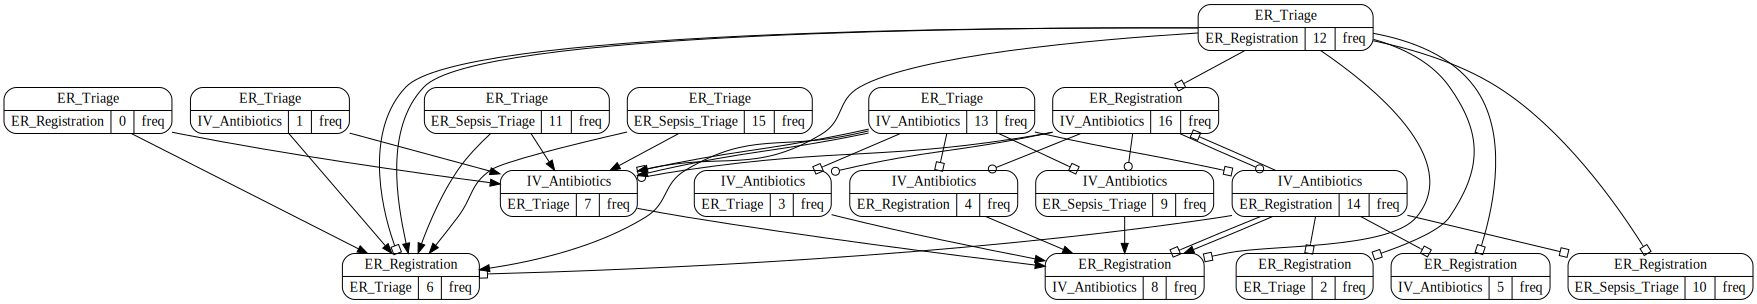

In [9]:
visualize(skeleton,actv_log_freq)